In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate();
using Altro
using TrajectoryOptimization
using RobotDynamics
using StaticArrays
using LinearAlgebra

  Activating environment at `~/.julia/dev/AltroTutorials/Project.toml`


# Cartpole: Adding Constraints
Now that you're familiar with the basics of defining a dynamics model, creating a quadratic cost function, and solving the problem, let's starting adding constraints. In this example we'll be working with the canonical cartpole system, and adding constraints on the torque and lateral movement.

## 1. Defining the Dynamics Model
The setup for the dynamics here is nearly identical to the setup we used previously on the pendulum. Just a few things to note:
* We used `Base.@kwdef` in front of `struct` to allow us to provide default values for the model parameters directly in the struct. This is often much more convenient than defining your own custom constructors.
* In the dynamics we made extensive use of StaticArrays to eliminate memory allocations and make it fast.

In [2]:
Base.@kwdef struct Cartpole{T} <: AbstractModel
    mc::T = 1.0
    mp::T = 0.2
    l::T = 0.5
    g::T = 9.81
end

function RobotDynamics.dynamics(model::Cartpole, x, u)
    mc = model.mc   # mass of the cart in kg (10)
    mp = model.mp   # mass of the pole (point mass at the end) in kg
    l = model.l     # length of the pole in m
    g = model.g     # gravity m/s^2

    q = x[ @SVector [1,2] ]  # must indepx with a static index vector to get a static array out
    qd = x[ @SVector [3,4] ]

    s = sin(q[2])
    c = cos(q[2])

    H = @SMatrix [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = @SMatrix [0 -mp*qd[2]*l*s; 0 0]
    G = @SVector [0, mp*g*l*s]
    B = @SVector [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    return [qd; qdd]
end

RobotDynamics.state_dim(::Cartpole) = 4
RobotDynamics.control_dim(::Cartpole) = 1

## 2. Defining the Cost Function
For this problem we'll use the same LQR-style quadratic cost, penalizing distance from the goal state.

In [3]:
# Get the model sizes
model = Cartpole()
n,m = size(model)

# Set model discretization
N = 101
tf = 5.0
dt = tf/(N-1);

In [4]:
# Define the Cost matrices
Q = 1e-2*Diagonal(@SVector ones(n))
Qf = 1e2*Diagonal(@SVector ones(n))
R = 1e-1*Diagonal(@SVector ones(m))

# Define the initial and final states
x0 = @SVector zeros(n)
xf = @SVector [0, pi, 0, 0]

# Define the objective
obj = LQRObjective(Q,R,Qf,xf,N);

## 3. Adding Constraints
Okay, now that we're through the stuff you should already know after going through the pendulum example, let's move on to the new stuff. We want to add constraints to this system. As a first step, let's add a goal constraint to make sure we hit the goal exactly (at least to the precision of our solve), and add torque limits.

The first step to adding constraints is creating a [`ConstraintList`](http://roboticexplorationlab.org/TrajectoryOptimization.jl/dev/constraint_api.html#TrajectoryOptimization.ConstraintList). This is a fairly basic type that holds a vector of constraints and specifies which knot points each constraint applies to. In TrajectoryOptimization.jl, each constraint is allowed to apply to a set of knot points, all of which must be adjacent. For example, I can apply a constraint to knot points `[1,2,3,4]` or `[5,6]`, or even just `[11]`, but not `[1,3,5]`.

Adding constraints usually happens in three steps:
1. Create the `ConstraintList`
2. Define the constraint function objects
3. Add the constraints to `ConstraintList`

We'll break this down in code below.

In [5]:
# 1. Create the ConstraintList
conSet = ConstraintList(n,m,N)

ConstraintList(4, 1, TrajectoryOptimization.AbstractConstraint[], UnitRange{Int64}[], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Easy enough. We have to provide the problem sizes so that the list can make sure the constraints we add are all compatible with those sizes.

In [6]:
# 2. Define the constraint function objects
u_bnd = 3.0
bnd = BoundConstraint(n,m, u_min=-u_bnd, u_max=u_bnd)
goal = GoalConstraint(xf)

GoalConstraint{4, Float64}(4, [0.0, 3.141592653589793, 0.0, 0.0], [1, 2, 3, 4])

Here we created 2 new objects, a [`BoundConstraint`](http://roboticexplorationlab.org/TrajectoryOptimization.jl/dev/constraint_api.html#TrajectoryOptimization.BoundConstraint) and a [`GoalConstraint`](http://roboticexplorationlab.org/TrajectoryOptimization.jl/dev/constraint_api.html#TrajectoryOptimization.GoalConstraint). These are both sub-types of [`TrajectoryOptimization.AbstractConstraint`](http://roboticexplorationlab.org/TrajectoryOptimization.jl/dev/constraint_interface.html#TrajectoryOptimization.AbstractConstraint) (more on that later). These are both defined in TrajectoryOptimization.jl, and provide the methods necessary to evaluate the function and it's Jacobian. We'll cover defining your own constraints in a later example. For now you just need to know that these types implement the methods the solver will need to satisfy the constraints. 

In [7]:
# 3. Add the constraints to ConstraintList
add_constraint!(conSet, bnd, 1:N-1)
add_constraint!(conSet, goal, N)

Here we used the `add_constraint!` method (note that it's a mutating function since it's modifying `conSet`) to add the constraints, specifying the knot point indices to which the constraint applies. Note that for the terminal constraint, we passed in a single index, but could have also passed in the range `N:N`.

**NOTE**: Be very careful when applying constraints to the entire trajectory. Altro assumes the constraints are independent and can emit strange error messages and failure modes when this is not the case (typically these happen in the projected Newton solution-polishing phase and say something about bad indexing). For example, if I had a bound on the states and applied those to the terminal state in addition to a goal constraint, the bound constraint would be redundant (and possibly infeasible). This will usually cause the solve to fail. Right now Altro.jl does not have a method for detecting this redundancy, so it is left to you, the user, the think carefully about your constraints. 

## 4. Defining the Problem
We now proceed back to familiar territory, and create a `Problem` object, but this time passing in our `ConstraintList`. Remember to provide an initial guess!

In [8]:
prob = Problem(model, obj, xf, tf, x0=x0, constraints=conSet);

# initial condition
U0 = [fill(0.01, m) for k = 1:N-1]
initial_controls!(prob, U0)

## 5. Create the solver and solve
Again, everything is the same here now that we've defined our problem. Under the hood, a few different things are happening since we're solving a constrained problem instead of an unconstrained one, but the interface is the same.

In [9]:
solver = ALTROSolver(prob);
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 88
    Solve Time: 5031.943584 (ms)

  Covergence
    Terminal Cost: 1.4973195087213034
    Terminal dJ: -3.934382825487859e-5
    Terminal gradient: 0.0006495892428091425
    Terminal constraint violation: 2.007421056049452e-7
    Solve Status: SOLVE_SUCCEEDED


## 6. Plotting the results
Let's look at some graphs to visualize the result. RobotDynamics provides a few plotting "recipes" for plotting trajectories, which we'll use with `Plots.jl` to easily generate plots of our state and control trajectories. Note that it'll take a while to generate the first plot (the infamous TTFP, or time to first plot, problem in Julia).

When plotting the states, we use the keyword `inds` and pass in a range to extract out the first 2 states, which are the position of the cart and the angle of the pole.

In [11]:
using Plots
pyplot()

Plots.PyPlotBackend()

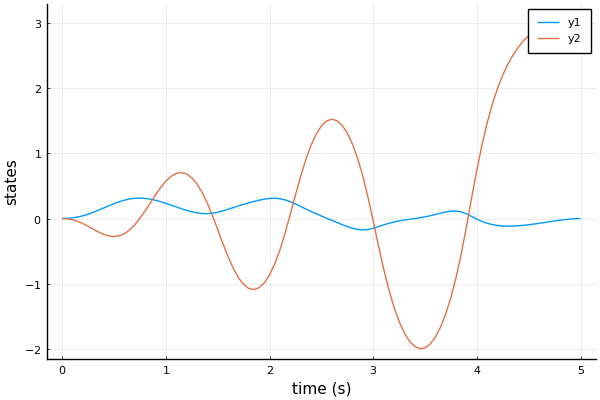

In [12]:
plot(get_times(solver), states(solver), inds=1:2, xlabel="time (s)", ylabel="states")

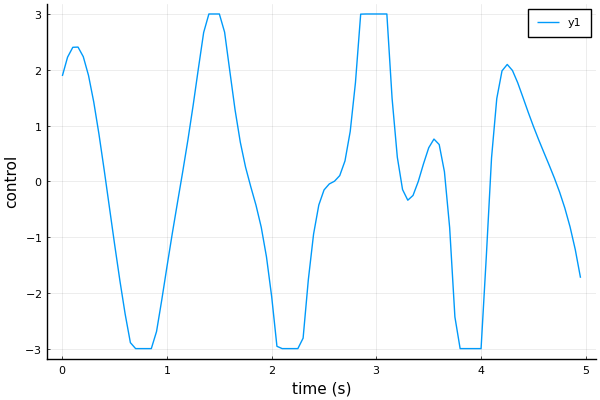

In [13]:
plot(get_times(solver)[1:N-1], controls(solver), xlabel="time (s)", ylabel="control")

As you can see, we're saturating our controls and taking multiple "pumps" to swing up, so it's doing what we're expecting it to!

## 7. Changing Solver Parameters
Now let's see if we can get it to solve a little faster. As with most optimization, the convergence is affected by a wide variety of solver hyperparameters. The ones we change here are usually the best ones to play around with.


### Convergence Criteria
Let's start by modifying our convergence criteria. But even before that, let's check what our current criteria are:

In [14]:
# Get the solver options
opts = Altro.options(solver)

SolverOptions{Float64}
  constraint_tolerance: Float64 1.0e-6
  cost_tolerance: Float64 0.0001
  cost_tolerance_intermediate: Float64 0.0001
  gradient_tolerance: Float64 10.0
  gradient_tolerance_intermediate: Float64 1.0
  iterations_inner: Int64 300
  dJ_counter_limit: Int64 10
  square_root: Bool false
  line_search_lower_bound: Float64 1.0e-8
  line_search_upper_bound: Float64 10.0
  iterations_linesearch: Int64 20
  max_cost_value: Float64 1.0e8
  max_state_value: Float64 1.0e8
  max_control_value: Float64 1.0e8
  static_bp: Bool true
  save_S: Bool false
  bp_reg: Bool false
  bp_reg_initial: Float64 0.0
  bp_reg_increase_factor: Float64 1.6
  bp_reg_max: Float64 1.0e8
  bp_reg_min: Float64 1.0e-8
  bp_reg_type: Symbol control
  bp_reg_fp: Float64 10.0
  penalty_initial: Float64 1.0
  penalty_scaling: Float64 10.0
  active_set_tolerance_al: Float64 0.001
  dual_max: Float64 1.0e8
  penalty_max: Float64 1.0e8
  iterations_outer: Int64 30
  kickout_max_penalty: Bool false
  reset_

Wow, that's a lot of options! Don't worry, you'll never have to even touch most of them, but we'll cover the most important ones as we move through the rest of the examples. For now, let's look at our convergence criteria:
* Cost Tolerance: changes in cost between interations must be less than this value
* Constraint Tolerance: maximum constraint violation must be less than this value
* Gradient Tolerance: the gradient of our optimality condition must be less than this value. This means we can't really make any more progress on reducing our cost. In practice, this can sometimes be difficult to satisfy, so we use a fairly large default value. Also, typically we don't care too much about minimizing the cost, since it's an arbitrary cost function that doesn't usually represent *exactly* what we want the system to do. 

In [15]:
@show opts.cost_tolerance
@show opts.constraint_tolerance
@show opts.gradient_tolerance;

opts.cost_tolerance = 0.0001
opts.constraint_tolerance = 1.0e-6
opts.gradient_tolerance = 10.0


If we want to relax (or tighten) these tolerances, we can do that in a couple of ways:
1. When we create the solver, specify them as keyword arguments
2. Use the `set_options!` command
3. Modify the options structure directly
4. Pass in a solver options struct when the solver is created (recommended)

We'll demonstrate these below:

In [16]:
# 1. As keyword arguments in the constructor
solver = ALTROSolver(prob, cost_tolerance=1e-3, constraint_tolerance=1e-3)

# 2. With the `set_options!` command
set_options!(solver, cost_tolerance=1e-3, constraint_tolerance=1e-3)

# 3. Setting them directly
solver.opts.cost_tolerance = 1e-3
solver.opts.constraint_tolerance = 1e-3

# 4. Via Options struct
opts = SolverOptions(cost_tolerance=1e-3)  # set in constructor
opts.constraint_tolerance = 1e-3           # OR set afterwards
solver = ALTROSolver(prob, opts);

Let's solve it again and compare it with the solve with the default tolerances:

In [17]:
solver = ALTROSolver(prob)
initial_controls!(solver, U0)
solve!(solver);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 88
    Solve Time: 9.098637 (ms)

  Covergence
    Terminal Cost: 1.4973195087213034
    Terminal dJ: -3.934382825487859e-5
    Terminal gradient: 0.0006495892428091425
    Terminal constraint violation: 2.007421056049452e-7
    Solve Status: SOLVE_SUCCEEDED


In [18]:
solver2 = ALTROSolver(copy(prob), opts)  # note the copy around the problem, since by default it'll use the same trajectories
initial_controls!(solver2, U0)
solve!(solver2);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 87
    Solve Time: 8.101683999999999 (ms)

  Covergence
    Terminal Cost: 1.4972801648930485
    Terminal dJ: 2.0311150522145383e-5
    Terminal gradient: 0.005411044600531603
    Terminal constraint violation: 0.0002642553927056923
    Solve Status: SOLVE_SUCCEEDED


You'll see that we only took one less iteration, but that the terminal constraint and gradient values are larger. We can query the max violation directly from the solver:

In [19]:
@show max_violation(solver)
@show max_violation(solver2);

max_violation(solver) = 2.007421056049452e-7
max_violation(solver2) = 0.0002642553927056923


If we want a more info on *where* the max violation is, we can use `TrajectoryOptimization.findmax_violation`:

In [20]:
TrajectoryOptimization.findmax_violation(solver2)

"typename(GoalConstraint) at time step 101 at index 2"

Which tells us that the max violation is due to the goal constraint at the last time step at index 2, which is the pendulum angle.

### Improving the Solve
So we saw that changing the convergence criteria didn't really change things too much for us. Let's see if we can change how the solver converges during the solve, not just at the end. The parameters we change should be your go-to parameters for performance tuning ALTRO. Note that we changed the verbosity level to `1` to print out just the outer loop iterations. Changing it to `2` will print out the iLQR iterations as well.

In [21]:
opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=10.,
    penalty_initial=1.0,
    verbose=1,
)
solver3 = ALTROSolver(copy(prob), opts)
initial_controls!(solver3, U0)
solve!(solver3);

iter  total  c_max       cost      penalty   info                                              
-----------------------------------------------------------------------------------------------
1     34      0.02568411  1.562007  1        
2     35      0.02215689  1.571363  10       
3     37      0.01279985  1.565029  100      



SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 40
    Solve Time: 797.8342799999999 (ms)

  Covergence
    Terminal Cost: 1.5525585573254304
    Terminal dJ: -0.0010405745407844336
    Terminal gradient: 0.0031063488952173747
    Terminal constraint violation: 3.4246685487460127e-9
    Solve Status: SOLVE_SUCCEEDED


4     39      0.00048612  1.551518  1000     


We more than halved the number of iterations! For tuning these parameters, we've found the following rules of thumb to be helpful:
* Change `penalty_initial` first. If solving an unconstrained version of your problem will give you a good initial guess, make it small (e.g. 1e-3). If you've provided a good initial guess that is mostly feasible, use a higher penalty (e.g. 1e3).
* Relaxing `cost_tolerance_intermediate` means that the iLQR iterations won't converge tightly every time, so you'll take more outer loop iterations. This can be helpful to crank down on constraint tolerances quickly. Generally keep this the same or nearly the same as `constraint_tolerance`, and only it change it at the end when you want to dial in the last bit of performance.
* Increase `penalty_scaling` between 10-100 (sometimes a little more) last. This will help drive the constraint violations down quickly, but can result in premature ill-conditioning if your penalty values get too large.